In [15]:
%matplotlib inline 
import numpy as np                       
from matplotlib import pyplot as plt      
import time, sys                   

## Задача Сода

Бесконечная труба заполнена воздухом ($\gamma = 1.4$), в точке $x = 0$ разделена перегородкой. При $t = 0$ слева от перегородки $(\rho, u, p)^T = (1, 0, 1)$, справа - $(\rho, u, p)^T = (0.125, 0, 0.1)$, где $\rho$ - плотность газа, $u$ - его скорость, $p$ - давление. Найти решение в момент времени $t\approx 0.504$. Считать воздух идеальным газом.

Уравнения газовой динамики и численный метод выписаны в книге [1], c.112-117. Там же приводятся графики решения, с которыми надо сверять свое решение.
1. Зализняк В.Е. Основы вычислительной физики. Часть 1. Введение в конечно-разностные методы

### Задание

Часть 1:
1. Реализовать все недостающие функции
2. Получить решение с постоянным шагом $\tau = 0.001$
3. Получить решение c $\tau_k = r\tau_{max}$, $\tau_{max}$ зависит от решения на текущем шаге. Постройте график зависимости $\tau_k$ от номера шага.
4. Прокомментировать решение, полученное в двух предыдущих пунктах
5. Укажите положение ударной волны и контактного разрыва
6. Прокомментируйте допустимость предложенного в коде варианта задания граничных условий. Стоит ли его заменить?

Часть 2: 
1. Реализуйте схему с искусственной вязкостью и проведите расчет в согласии с пунктом 3.
2. Прокомментируйте решение.

### Схема Лакса-Вендроффа для решения задачи Сода

Примитивные переменные $(\rho, u, p)^T$, консервативные - $(\rho, \rho u, \rho(e + u^2/2))$.

In [16]:
nx = 101  # количество узлов по пространству
h = 2 / (nx-1) # шаг по пространству
x_mesh = np.linspace(-1, 1, nx) #сетка по пространству
gamma = 1.4 # показатель адиабаты

In [17]:
# Пересчет прититивных переменных в консервативные
def primToCons(pv):
    rho = pv[0]
    u = pv[1]
    p = pv[2]
    ekin = 0.5*u**2
    return np.array([rho, rho*u, p/(gamma - 1) + rho*ekin])

# Пересчет консервативныx переменных в примитивные (обратное выражение)
def consToPrim(s):
    rho = s[0]
    u = s[1] / rho
    ekin = 0.5 * u**2
    p = (s[2] - ekin*rho) * (gamma-1)
    return np.array([rho, u, p])

# Вычисление потока f(s)
def flux(s):
    prim = consToPrim(s)
    p = prim[2]
    return np.array([s[1], (s[1]**2)/s[0] + p, (s[1]/s[0]) * (s[2] + p)])

# Cхема Лакса-Вендроффа
# snm1, sn, snp1 - узлы шаблона со временного слоя k
def LaxWendroff(snm1, sn, snp1, tau, h):
    s_inc = (snp1 + sn)/2 - tau * (flux(snp1) - flux(sn))/(2 * h)
    s_dec = (snm1 + sn)/2 - tau * (flux(sn) - flux(snm1))/(2 * h) 
# Теперь нужно подставить s_inc, s_dec в функцию f
    return sn - tau * (flux(s_inc) - flux(s_dec))/h

# Вычисление шага по времени
def get_tau(h, sk):
    primitive = np.array([consToPrim(s) for s in sk])
    r = 0.9 # число Куранта
    tau_k = h/np.max(np.abs(primitive[:,1]) + (gamma*primitive[:,2]/primitive[:,0])**0.5)
    return r*tau_k

#### Начальное условие

In [18]:
s0 = np.zeros((nx, 3))
pvl = np.array([1,0,1])
pvr = np.array([0.125, 0, 0.1])
s0[:int(nx/2) + 1] = primToCons(pvl)
s0[int(nx/2) + 1:] = primToCons(pvr)

#### Численное решение ($\tau$ = const)

In [19]:
skp1 = s0.copy() # решение на слое k+1
sk = s0.copy() # решение на слое k
t = 0
while t < 0.5:  # шагаем по времени
    sk = skp1.copy() # заполняем данными с предыдущего шага
    tau = 0.001 # здесь постоянный шаг
    for n in range(1, nx - 1): # шагаем по пространству без первого и последнего узлов - их определим в граничных условиях
        skp1[n] = LaxWendroff(sk[n - 1], sk[n], sk[n + 1], tau, h)
    # левое граничное условие
    skp1[0] = primToCons(pvl)
    # правое граничное условие
    skp1[nx - 1] = primToCons(pvr)
    t = t + tau

#### Визуализация решения

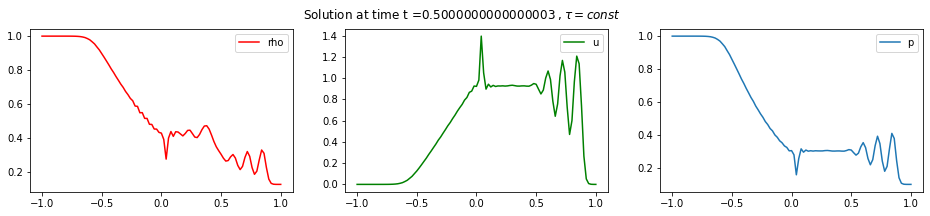

In [20]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t ='  + str(t) + '$\\;, {\\tau = const}$')
plt.show()

#### Численное решение ($\tau \neq$  const)

In [21]:
taus = [] # список для построения графика
skp1 = s0.copy() # решение на слое k+1
sk = s0.copy() # решение на слое k
t = 0
while t < 0.5:  # шагаем по времени
    sk = skp1.copy() # заполняем данными с предыдущего шага
    tau = get_tau(h, sk) # здесь переменный шаг
    for n in range(1, nx - 1): # шагаем по пространству без первого и последнего узлов - их определим в граничных условиях
        skp1[n] = LaxWendroff(sk[n - 1], sk[n], sk[n + 1], tau, h)
    # левое граничное условие
    skp1[0] = primToCons(pvl)
    # правое граничное условие
    skp1[nx - 1] = primToCons(pvr)
    t = t + tau
    taus.append(tau)
    

#### Визуализация решения

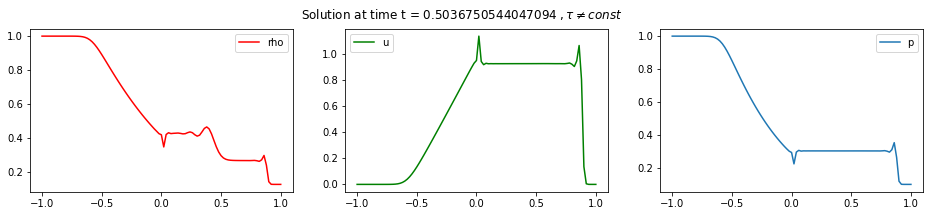

In [22]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t) + '$\\;, {\\tau \\neq const}$')
plt.show()

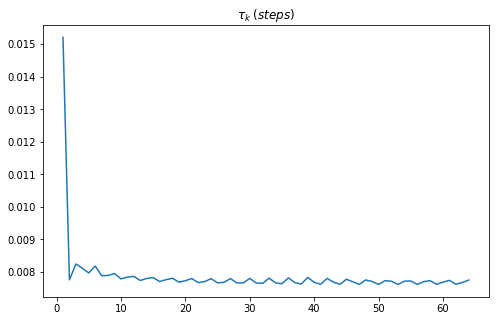

In [23]:
steps = np.arange(1, len(taus) + 1)
plt.figure(figsize = (8, 5))
plt.title('$\\tau_k \\;(steps)$')
plt.plot(steps, taus)
plt.show()

#### Ответы на теоретическую составляющую

4] Анализируя графики, наблюдаем колебания решения с постоянным шагом вблизи точек разрыва. Из-за того, что шаг по времени мал, в точках разрыва решение медленно сходится - наблюдаем колебания на графике. 

Напротив, у решения с подобраным шагом осциляции отсутствуют. Подобраный шаг не будет столь мал, более того даже с таким шагом система будет устойчива (в нашем коде этот шаг подбирается из "анализа устойчивости системы 6.4, стр. 114 чудо книги" [1]).


5] Из того же анализа графиков видим положение ударной волны находится в интервале $x \in \;$(0.8 ; 0.9) (точка разрыва). Правее этого интервала параметры зануляются (в данные момент времени волна туда ещё не дошла).

Контактный разрыв анализируем по графику параметра $\rho$. Видим, что правее точки $x \approx 0.4 \;$, $\rho$ стремительно уменьшается, значит в этой точке и находится контактный разрыв.  


6] Предложенный вариант задания граничных условий допустим. Соответствует моменту распадения конфигурации функции состояния на две волны (в нулевой момент времени, когда убрали перегородку). Вправо распространяется контактный разрыв и ударная волна, а влево - волна разрежения (стр. 117 "чудо книги" [1]).

### Часть 2.

#### Схема с искусственной вязкостью

Нам понадобятся формулы изменённой схемы Лакса-Вендроффа из [1] и нового подобранного шага, така как схема требует более строгое ограничение на него.


Схема:
$$
s_{n}^{k+1}={s}_{n}^{k}-\frac{\tau_{k}}{h}\left({f}_{n+1 / 2}^{k+1 / 2}-{f}_{n-1 / 2}^{k+1 / 2}\right)+{\mu}_{a}^{k} \tau_{k}\left({s}_{n+1}^{k}-2 {s}_{n}^{k}+{s}_{n-1}^{k}\right)
$$

Определяем:
$${\nu = \mu^{k}_{a}\tau_k}$$

Новые ограничение на шаг:
$$
\tau_{k} \leqslant \tau_{\max } \sqrt{1-2 \nu}
$$

In [24]:
# Cхема Лакса-Вендроффа - её необходимо переопределить как и вычисление шага
# Возьмём nu = 0.06 как в примере из "чудо книги" [1]
# snm1, sn, snp1 - узлы шаблона со временного слоя k
def LaxWendroff(nu, snm1, sn, snp1, tau, h):
    s_inc = (snp1 + sn)/2 - tau * (flux(snp1) - flux(sn))/(2 * h)
    s_dec = (snm1 + sn)/2 - tau * (flux(sn) - flux(snm1))/(2 * h) 
# Теперь нужно подставить s_inc, s_dec в функцию f
    return sn - tau * (flux(s_inc) - flux(s_dec))/h + nu*(snp1 - 2*sn + snm1)

# Вычисление шага по времени
def get_tau(nu, h, sk):
    primitive = np.array([consToPrim(s) for s in sk])
    r = 0.9 # число Куранта
    tau_k = h/np.max(np.abs(primitive[:,1]) + (gamma*primitive[:,2]/primitive[:,0])**0.5)
    return tau_k * np.sqrt(1 - nu*2)

#### Начальное условие

In [25]:
s0 = np.zeros((nx, 3))
pvl = np.array([1,0,1])
pvr = np.array([0.125, 0, 0.1])
s0[:int(nx/2) + 1] = primToCons(pvl)
s0[int(nx/2) + 1:] = primToCons(pvr)

#### Численное решение

In [26]:
taus = []
skp1 = s0.copy() # решение на слое k+1
sk = s0.copy() # решение на слое k
t = 0
while t < 0.5:  # шагаем по времени
    sk = skp1.copy() # заполняем данными с предыдущего шага
    tau = get_tau(0.06, h, sk) # здесь переменный шаг
    for n in range(1, nx - 1): # шагаем по пространству без первого и последнего узлов - их определим в граничных условиях
        skp1[n] = LaxWendroff(0.06, sk[n - 1], sk[n], sk[n + 1], tau, h)
    # левое граничное условие
    skp1[0] = primToCons(pvl)
    # правое граничное условие
    skp1[nx - 1] = primToCons(pvr)
    t = t + tau
    taus.append(tau) 

#### Визуализация решения

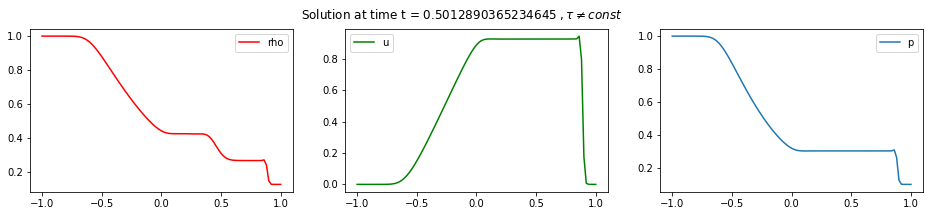

In [27]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t) + '$\\;, {\\tau \\neq const}$')
plt.show()

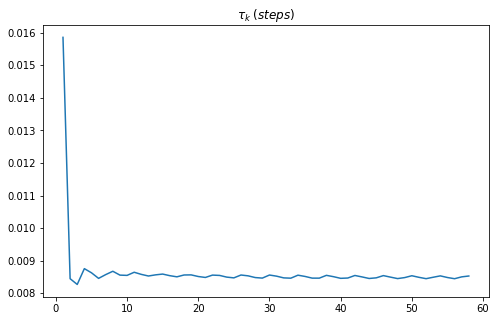

In [28]:
steps = np.arange(1, len(taus) + 1)
plt.figure(figsize = (8, 5))
plt.title('$\\tau_k \\;(steps)$')
plt.plot(steps, taus)
plt.show()

стр. 120 "чудо книги" [1] 

"Введение искуственной вязкости позволяет подавлять нефизические осцилляции приближённого решения, хотя это достигается за счёт некоторого размазывания разрывов."

Наблюдаем описанное выше на графике. По сравнению с решениями без введения искуственной вязкости на текущих графиках полностью отсутствуют колебания и разрывы действительно размазаны (не так ярко выражены как раньше, но всё же видны).